# Conformal Prediction

The sparsity of observed instances gravely influences the degree of confidence a model prediction could have. Conformal prediction is an applicative technique that adds calibration process on top of any models to quantify uncertainties in data for both point estimators and prediction intervals. 

While there are different ways to carry out conformal prediction, NeuralProphet adopts the split conformal prediction, which requires a holdout or calibration set. To carry out split conformal prediction, the dataset has to be split into three distinct sets for training, calibration and testing respectively. An initial prediction interval is created with the base quantile regression model trained by the training dataset. Target variables in the calibration set are being compared to the predicted value, which is denoted as the [quantified uncertainty](https://towardsdatascience.com/conformal-prediction-4775e78b47b6). The final conformal prediction interval is then formed by adding the quantified uncertainty to both tails of the predicted value.

You might select `Naive` (*naive*) or `Conformal Quantile Regression` (*CQR*) for the conformal prediction in NeuralProphet. Here, we illustrate and further elaborate on the conformal prediction naive and CQR module using the hospital electric load dataset. The dataset has recorded the electricity consumption of a hospital in SF in 2015 by hour.

In [1]:
# much faster using the following code, but may not have the latest upgrades/bugfixes
# !pip install neuralprophet  

if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git  # may take a while

In [2]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

data_location = "http://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df = pd.read_csv(data_location + "energy/SF_hospital_load.csv")

/Users/christytse/Desktop/NP/neuralProphetProd/lib/python3.10/site-packages/plotly_resampler/aggregation/aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


### Data splitting

At least three subsets (i.e. testing, calibration and testing) are needed in the conformal prediction feature in NeuralProphet. You may choose to opt in a validation subset in this model. If you want to add in a validation subset to train the base model, please make sure the period of the validation subset must be in between of the training and calibration subsets. In NeuralProphet, there is a data splitting function which divide a dataset input into two subsets. You can configure the function by indicating the time series frequencies and splitting ratio. List of frequency aliases can be found <a href= 'https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases'>here</a>.


In our hospital electric load dataset, we will first divide the original dataset into training and testing set with a train-test ratio of $1/16$ and then further divide the calibation set from the training set with a train-calibration ratio of $1/11$.

In [3]:
# Create NeuralProphet object 
m = NeuralProphet()

# Data spliting function split one timeseries dataframe into two
# Configure the hourly frequency by assigning 'H' to parameter freq
# Configure the splitting ratio with a value between 0 and 1 for valid_p
train_df, test_df = m.split_df(df, freq="H", valid_p=1.0/16)
train_df, cal_df = m.split_df(train_df, freq="H", valid_p=1.0/11)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


After splitting, we will have 7467, 746 and 547 instances extracted in sequence as training, calibration and testing set respectively.

In [4]:
train_df.shape, cal_df.shape, test_df.shape

((7467, 2), (746, 2), (547, 2))

In [5]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-11-08 03:00:00
Calibration set time range:  2015-11-08 04:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


### Base model training
You can build any NeuralProphet model you deemed as fit as the base model. The calibration process in conformal prediction would be later added on the base model to quantify the uncertainty in our final estimation.

Back to our example, assuming we want to build an autoregression NeuralProphet model which can be providing us a prediction interval with 90% of confidence level. Thus we create a three-quantiles model that outputs the 5th, 50th and 95th percentile values. You can refer to the [NeuralProphet](https://neuralprophet.com/tutorials/tutorials.html), [Autoregression](https://neuralprophet.com/notebooks/autoregression_yosemite_temps.html) and [Uncertainty Estimation with Quantile Regression](https://github.com/ourownstory/neural_prophet/blob/main/tutorials/feature-use/uncertainty_quantile_regression.ipynb)  standalone tutorial sessions for the logic and applications of the features. We will be comparing the conformal prediction results between a simple and a complex 4-layer autoregression model in our illustration here.

In [6]:
#Parameter for autoregression
#Predict the value in the next hours based on the last three daysin an-hour steps
n_lags = 3 * 24 

#Parameter for quantile regression
confidence_lv = 0.9  
quantile_list = [round(((1 - confidence_lv) / 2), 2), 
                 confidence_lv + (1 - confidence_lv) / 2]

In [7]:
#Create a simple quantile regression model
m1 = NeuralProphet(
    quantiles=quantile_list
)

#Create a 4-layer autoregression model as the base
m2 = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantile_list
)

After finish configuring the model, we fit the model with the train set. 

If you have further split the training dataset into training and validation, you can either (i) concatenate the two datasets in one dataset for training or (ii) assign the training and validation datasets as two separated parameters. You can know more about the validation procedure in the [Phase Train, Validate and Test procedure](https://neuralprophet.com/notebooks/test_and_crossvalidate.html#3.-Advanced:-3-Phase-Train,-Validate-and-Test-procedure).

In [8]:
#Feed the training subset in the configured NeuralProphet models
#Configure the hourly frequency by assigning 'H' to parameter freq
set_random_seed(0)
metrics1 = m1.fit(train_df, freq="H")
set_random_seed(0)
metrics2 = m2.fit(train_df, freq="H")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (234) is too small than the required number for the learning rate finder (246). The results might not be optimal.


Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111


Training: 0it [00:00, ?it/s]

We use the fitted base model to forecast both the point prediction and the quantile regression prediction intervals for the testing dataset. 

In [9]:
#Perform estimation for the testing data with the trained model
forecast1 = m1.predict(test_df)[n_lags:]
forecast2 = m2.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


We can then plot the predicted intervals (5th, 50th and 95th percentile values) to compare the performance of the models. With the same quantile parameter, the complex model has a much narrower prediction interval comparing to the simple model.

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


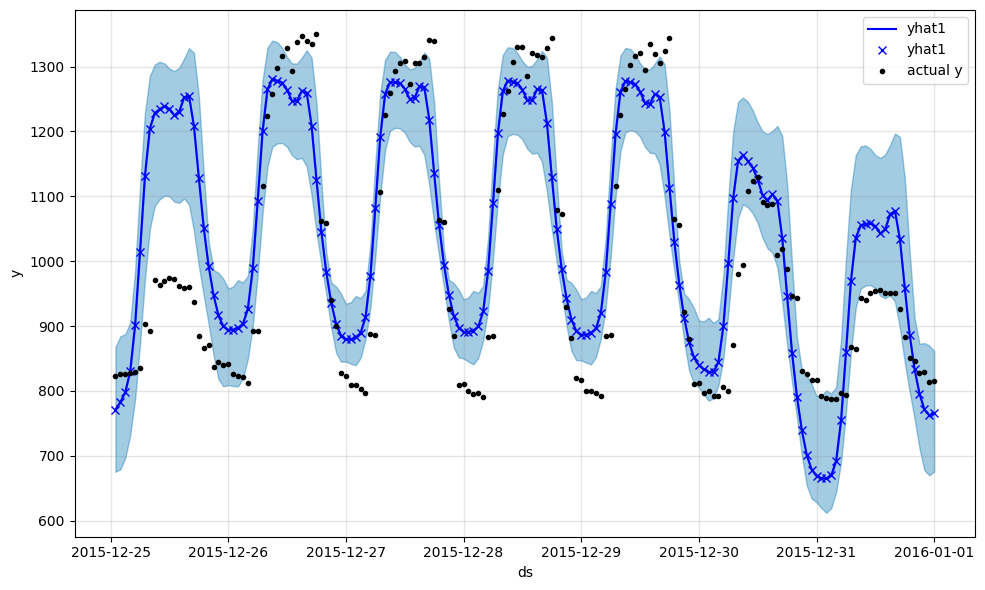

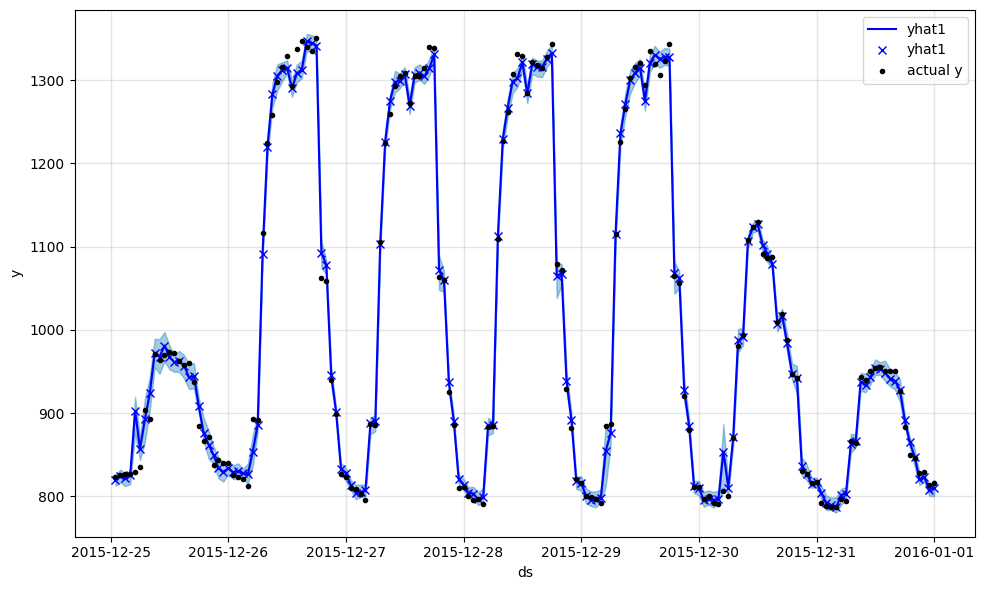

In [10]:
#Date range shown in the plots (optional)
cutoff = 7 * 24  
plotting_backend = "default"

#Plot the estimated value predicted with the base model
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast1[-cutoff:], plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    forecast2[-cutoff:], plotting_backend=plotting_backend
)

### Conformal Prediction
#### Option 1: Naive Conformal Prediction

After training the base model, we then carry out the calibration process using the naive module. The steps are outlined as follow:
<br>i. predict the output value of the instances within the calibration set;
<br>ii. calculate absolute residual by comparing the actual and predicted value for each observation in the calibration set;
<br>iii. sort all absolute residual in ascending order; and
<br>iv. finds the quantified uncertainty ($\hat{q}$) with the desired confidence level.
<br>v. use the quantified uncertainty ($\hat{q}$) to make the final prediciton intervals

Going back to our example, we need to denote the parameter value for calibration set, significant level (alpha) for conformal prediction on top of the pre-trained models above.

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


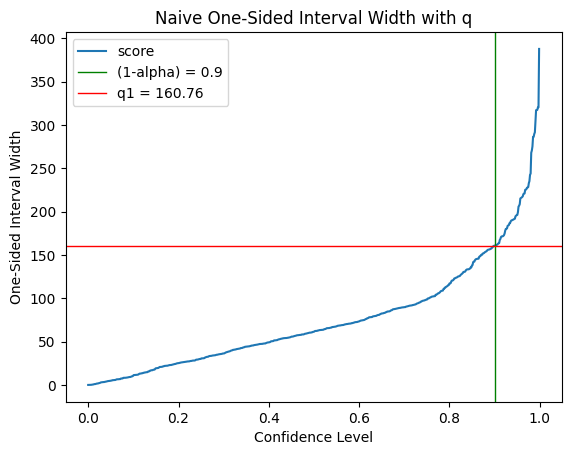

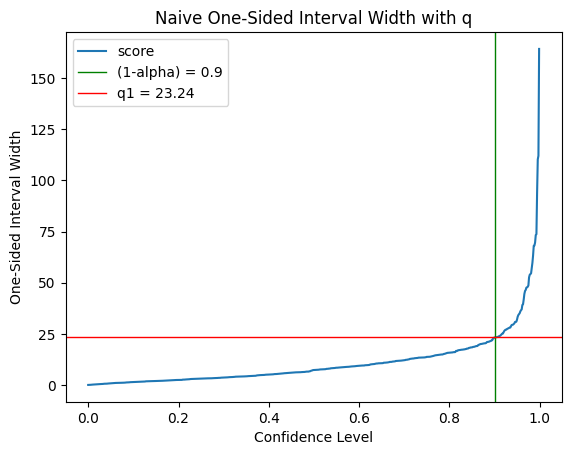

In [11]:
#Parameter for naive conformal prediction
method = "naive"
alpha = 1-confidence_lv
evaluate = True
plotting_backend = "default"

#Enable conformal predict on the pre-trained models
#Evaluate parameter is optional, refer to the "Evaluate Performance" session below
naive_forecast1, naive_eval1 = m1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    evaluate=evaluate,
    plotting_backend=plotting_backend
)
naive_forecast2, naive_eval2 = m2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    evaluate=evaluate,
    plotting_backend=plotting_backend
)

The plots above demonstrate how quantified uncertainty ($\hat{q}$) change with different confidence level (`1-alpha`).  In the Naive conformal prediction, uncertainty is quantified using the absolute residual . We calculate the  absolute residual for each instance within the calibration dataset and arrange the residual in an ascending order. The uncertainty ($\hat{q}$) is quantified by locating the absolute residual  at your desired confidence level. We will then add the uncertainty value ($\hat{q}$) to both sides of the prediction interval generated in the base model.

Below are the $\hat{q}$ values for each model. As they are all positive, you will see the naive interval extending beyond that of simple QR. The weaker model has a large gap between these two intervals since it has a larger $\hat{q}$ value, while for complex model, the bounds are shifted much less.

In [12]:
naive_qhat1 = naive_eval1["yhat1"].iloc[0]["qhat1"]   #m1
naive_qhat2 = naive_eval2["yhat1"].iloc[0]["qhat1"]   #m2

naive_qhat1, naive_qhat2

(160.75517819843753, 23.241478163281272)

We plot the conformal prediction intervals again with the quantified uncertainty included (in red) below. For the weaker model, the conformal prediction intervals has a wider width as such it can capture more more actual values than the quantile regression prediction intervals (in blue). The complex model in contrast has a much narrower prediction interval comparing to the simple model.

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


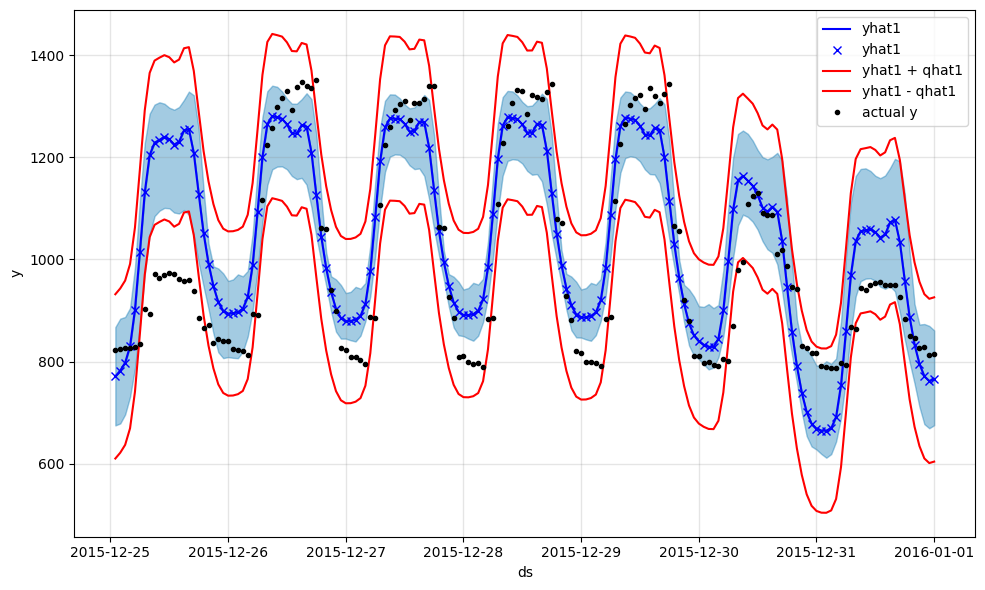

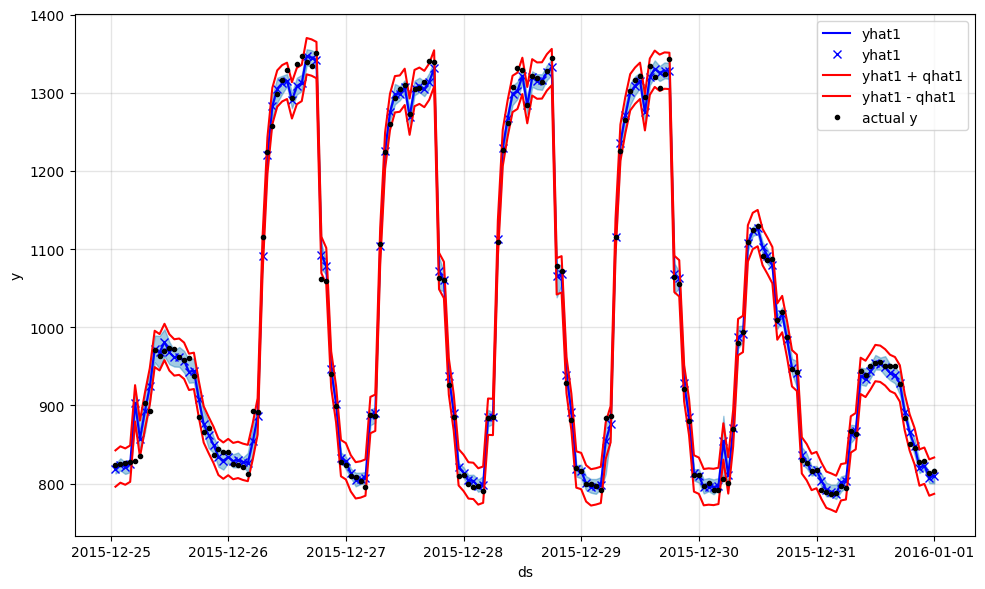

In [13]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast1[-cutoff:], plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast2[-cutoff:], plotting_backend=plotting_backend
)

#### Option 2: Conformal Quantile Regression

In [conformal quantile regression (CQR)](https://arxiv.org/abs/1905.03222), the method is run as follows:
<br>i. A sorted list of non-conformity scores is calculated as the differences between data points from the calibration dataset and their nearest prediction quantile, which provides a measure of how well the data fits the current quantile regression model.
<br>ii. The differences are calculated such they are negative for data points within the quantile regression interval and positive if they are outside the interval.
<br>iii. The quantiles from the regression model are adjusted by an amount that satisfies the desired error rate, which is the portion of data points lying outside the interval, based on the calibration data's non-conformity scores.

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 234it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 232it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


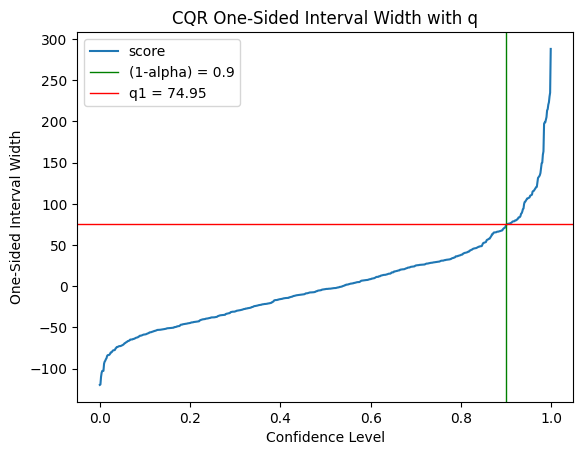

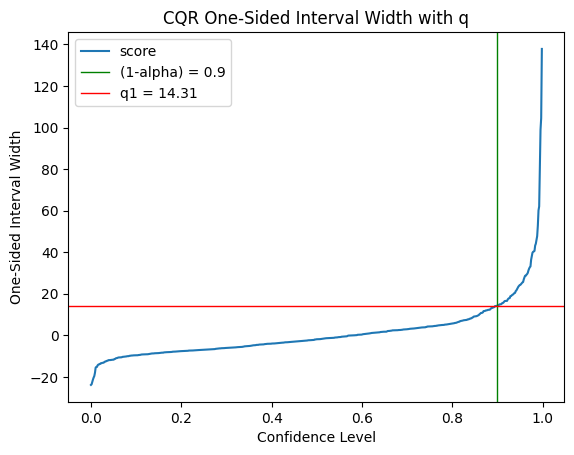

In [14]:
# Parameter for conformal quantile regression
method = "cqr"

# Enable conformal predict on the pre-trained models
#Evaluate parameter is optional, refer to the "Evaluate Performance" session below
cqr_forecast1, cqr_eval1 = m1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    evaluate=evaluate,
    plotting_backend=plotting_backend
)
cqr_forecast2, cqr_eval2 = m2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    evaluate=evaluate,
    plotting_backend=plotting_backend
)

The plots above show how the prediction interval bounds' adjustment, which is denoted $\hat{q}$, is calculated from the non-conformity scores of the calibration data and each quantile regression model m1 and m2. Given an error rate alpha, the sorted list of non-conformity scores yields a value of $\hat{q}$ such that the portion of scores in the list greater than $\hat{q}$ is equal to that error rate. What this means is that we update the prediction interval bounds based on the calibration data so that we are more reasonably confident that the training set data satisfies a similar error rate as alpha when compared to the new quantile regression model. There are two scenarios for what the CQR model means based on the value of $\hat{q}$.
- If the one-sided prediction interval width adjustment is **positive**, then CQR **extends** beyond the QR intervals, as it deems the QR interval to be too **confident**.
- Conversely, if the one-sided prediction interval width adjustment is **negative**, then CQR **contracts** the QR intervals, as it deems the QR interval to be too **conservative**.

Below are the $\hat{q}$ values for each model. As they are all positive, you will see the CQR interval extending beyond that of simple QR. Model m1 has a large gap between these two intervals since it has a larger $\hat{q}$ value, while for m2, the bounds are shifted much less.

In [15]:
cqr_qhat1 = cqr_eval1["yhat1"].iloc[0]["qhat1"]    #m1
cqr_qhat2 = cqr_eval2["yhat1"].iloc[0]["qhat1"]    #m2

cqr_qhat1, cqr_qhat2

(74.94926071718749, 14.310599375000038)

Plot QR forecasts and *CQR* conformal prediction interval with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


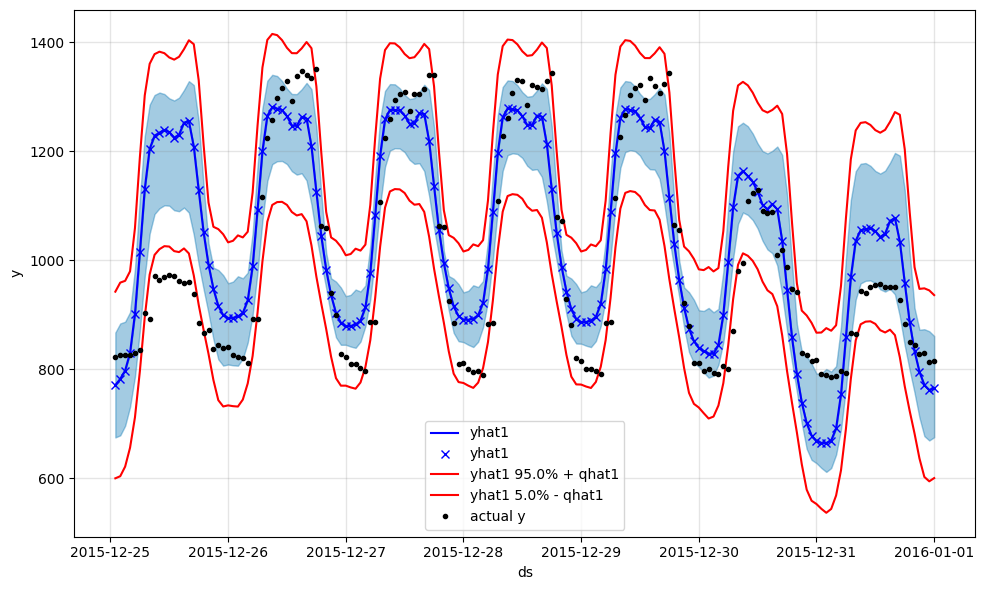

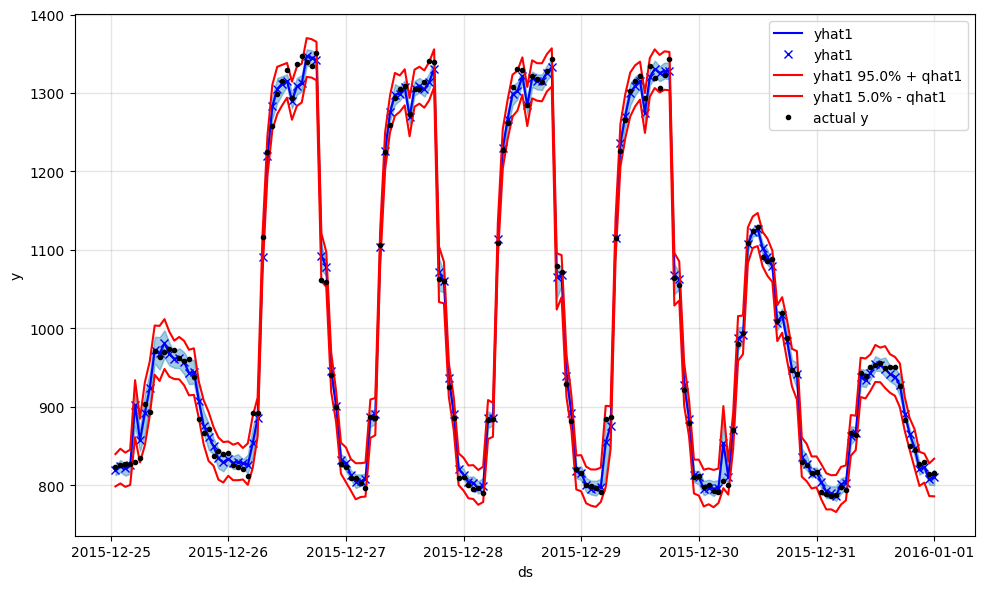

In [16]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast1[-cutoff:], plotting_backend=plotting_backend
)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast2[-cutoff:], plotting_backend=plotting_backend
)

### Evaluate Performance

We are using interval width and miscoverage rate as the performance metrics.
- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive, this is also knowns as the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set, this is also knowns as the *validity* metric.

The smaller the metrics are, the better the models are performing.

Let's test with the models we trained above. We first build a dataframe with two rows for the two models we trained and then we will concatenate the Naive and CQR performance metrics in the dataframe for the evaluation.

In [17]:
#Create evaluation dataframe skeleton with the 2 models (denoted as m1 and m2)  
models = ["m1", "m2"]
eval_df = pd.DataFrame(models, columns=pd.MultiIndex.from_tuples([("model", "", "")]))

We are aggregating the performance metrics for naive and put them in the evaluation dataframe skeleton at this session. The performance metrics are calculated when you have turned on the `evaluate` parameter in the conformal prediction feature.

In [18]:
#Aggregate the naive performance metrics for m1 and m2
naive_evals = [naive_eval1, naive_eval2]
naive_eval_df = pd.concat(naive_evals).reset_index(drop=True)

#Add 'naive' column level in-between yhat1 and metrics levels
naive_eval_df.columns = pd.MultiIndex.from_tuples([(x[0], "naive", x[1]) for x in naive_eval_df.columns])

#Aggregate the cqr performance metrics for m1 and m2
cqr_evals = [cqr_eval1, cqr_eval2]
cqr_eval_df = pd.concat(cqr_evals).reset_index(drop=True)

#Add 'cqr' column level in-between yhat1 and metrics levels
cqr_eval_df.columns = pd.MultiIndex.from_tuples([(x[0], "cqr", x[1]) for x in cqr_eval_df.columns])

Lastly, we concatenate the naive and cqr evaluation dataframes and then compare how the models are performing with the naive and cqr prediction.

In [19]:
#Concatenate the naive and cqr evaluation dataframes
eval_df = pd.concat([eval_df, naive_eval_df, cqr_eval_df], axis=1)
eval_df

model       yhat1                                                            \
              naive                                        cqr                  
              qhat1 interval_width miscoverage_rate      qhat1 interval_width   
0    m1  160.755178     321.510356         0.107861  74.949261     309.629541   
1    m2   23.241478      46.482956         0.077895  14.310599      49.381860   

                    
                    
  miscoverage_rate  
0         0.106033  
1         0.052632

**Performance of the trained model above**:

- This notebook is only using single forecast timestep models, hence we would only have `yhat1` as the point estimator.
- The `interval_width` doubles the quantified uncertainties (`qhat1`) for both the Naive conformal prediction, as such you will be seeing symmetrical prediction intervals.
- The complex model (m2) has a lower *interval width* and *miscoverage rate* than the simple model (m1). The simpler model (m1) have *miscoverage rate* bigger than the confidence level (*alpha* at 0.1) while the complex autoregressioin model (m2) have a *miscoverage rate* smaller than the confidence level. As such, we can conclude that the more complex the model is, the better the data are fitted and the more accurate the prediction are made. 
- When we are only looking at the simple quantile regression model (m1), CQR is more preferable as it has narrower prediction *interval width* and a slightly better *miscoverage rate* than Naive.
- As for the complex model (m2), both Naive and CQR are having comparable *interval_width* and *miscoverage rate*. You may want to feed the model with more data to determine which method more preferable.
